In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing

from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from metrics import *

In [32]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterA_high.csv',header=None)
scaler = MinMaxScaler()
scaler.fit(data)
# data = scaler.transform(data)*2-1

data = np.concatenate((data,data),axis=0)

In [4]:
class Bicluster(object):
    
    def __init__(self, data, rho=None, gamma=None, H = -1, HT = -1):
        """
        Bicluters structure
        
        :param rho: <np.array[int]> the map of the indices of rows of the bicluster i.e [2,4,7,8]
        :param gamma: <np.array[int]> the map of gammas, same structure f rho
        :param H: <float> the H values of the bicluster
        """
        self.gamma = gamma
        self.rho = rho
        self.H = H
        self.HT = HT
        self._mutation = 0
        self.data = data[np.ix_(self.rho, self.gamma)]
        
    @property
    def mutation(self):
        return self._mutation
    
    def __str__(self):
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))
    
    def row_length(self):
        return len(self.rho)
    
    def col_length(self):
        return len(self.gamma)
    
    def compute_H(self, data):
        """
        Method:
        Computes the coherence H of the data
        """
        if (self.H<0):
            self.H = PairBasedCoherence(data).HP
        return self.H

In [3]:
class MapArray(object):
    def __init__(self, map_array, flg_direction):
        """
        Array that will map the indices whether its a row map or a col map
        """
        self._map_array = map_array
        self._flg_direction = flg_direction
        
    @property
    def map_array(self):
        return self._map_array
    
    @property
    def flg_direction(self):
        return self._flg_direction


In [2]:
def split_cols(data):
    """
    Function:
    Spits the bicluster according to the best split in of columns
    
    :param data: <np.array[np.array]> data of the bicluster to split
    :param bicluster: <Bicluster> data 
    """
    map_array = MapArray(np.zeros(data.shape[1]),'cols')
    middle = 0
    max_h = 0
    for i in range(1,data.shape[1]):
        # print(" i " + str(i))
        temp_h_right = PairBasedCoherence(data[:,i:]).HP
        # print("right " + str(temp_h_right))
        temp_h_left = PairBasedCoherence(data[:,:i]).HP
        # print("left " + str(temp_h_left))
        temp_max = max(temp_h_right, temp_h_left)
        
        if (temp_max >= max_h):
            max_h = temp_max
            middle = i
            
    print(middle)
    map_array.map_array[0:middle] = np.ones(middle)
    print("Final map " + str(map_array.map_array))
    return map_array

In [10]:
def split_rows(data):
    """
    Apply DBSCAN over the bicluster to filter noise
    
    :param bicluster: <Bicluster> data
    """
    n_cols = data.shape[1]
    dm = np.asarray([[((PositiveNegativeCorrelation(p1,p2,len(p1)).H_pos) 
                       if (PositiveNegativeCorrelation(p1,p2,len(p1)).H_pos)!= 1 else 0.0) for p2 in data] for p1 in data])
    
    db = DBSCAN(eps=0.01,metric='precomputed', min_samples=5
           ).fit(1-dm**4)
    
    return db.labels_

In [5]:
def compute_objective_function(bicluster):
    

In [1]:
class STSSCAN(object):
    
    def __init__(self, data, n_clusters = 2):
        """
        STSSCAN
        
        Applies biclustering over data
        
        :param data: <np.array> The data to apply biclusters
        :param n_clusters: <int> The number of biclusters to find
        
        """
        assert data is not None, "Empty data"
        self._data = data
        """ Data to apply biclustering """
        self._I, self._J = self._data.shape
        """ Stores shape of data """
        self._n_clusters = n_clusters
        """ Number of clusters to find """
        self._biclusters = list()
        """ List of biclusters composed by Bicluster Class"""
        self._objective_function = 0
        """ Objective function: maximize with boundary 1"""
    
    @property
    def n_clusters(self):
        return self._n_clusters
    
    @property
    def data(self):
        return self._D
    
    @property
    def labels(self):
        return _labels
            
    def fit(self):
        """
        Fits the data on the algorithm. Iters over the 
        number of biclusters until find the requested number
        """
        n_iterations = 0
        n_clusters = 0
        initial_bicluster = Bicluster(self._data,np.arange(self._I), np.arange(self._J))
        self._biclusters.append()
        for n_iterations in range(0,n_clusters):
            self._split_biclusters()
                
    def _split_biclusters(self):
        
        """
        Splits bicluters in order to find the next biclusters that optimizes
        the sum of coherences among biclusters
        """
        """ Initialize variables """
        max_delta = 0
        tmp_bicluster_delta = 0
        tmp_bisection = MapArray()
        position = 0
        best_position = 0
        best_bisection = MapArray()
        """ Iterate over the biclusters"""
        for bicluster in self._biclusters:
            """ If shape of the biclusters is within the bounds """ 
            if (bicluster.row_length() >= (np.log(self._I)*5) and bicluster.col_length() >= 2):
                
                """ Compute the bicluster coherence """
                tmp_bicluster_delta = compute_bicluster_coherence(bicluster)
                
                """ Store the best split of biclusters """
                if(tmp_bicluster_delta >= max_delta):
                
                    max_delta = tmp_bicluster_delta
                    best_bicluster = bicluster
                    best_position = position
                    best_bisection = tmp_bisection
            position += 1
        """ Add the bicluster to the list of biclusters """
        self._add_bicluster(best_bicluster, best_position)
    
    def _add_bicluster(self, best_bicluster, best_position, bisection):
        """
        Adds the found bicluster into the list of labels
        """
        pass 
        """ If the bisection is on rows """
        if bisection.flg_direction == 'row':
            
            """Create and append the new bicluster spliting rows """
            self._labels[best_position] = Bicluster(best_bicluster.rho[np.flatnonzero(bisection.map_array == 0)]
                                                    ,best_bicluster.gamma)
            self._labels.append(Bicluster(best_bicluster.rho[np.flatnonzero(bisection.map_array == 1)]
                                                    ,best_bicluster.gamma))
        else:
            """Create and append the new bicluster spliting columns """
            self._labels[best_position] = Bicluster(best_bicluster.rho
                                                    ,best_bicluster.gamma[np.flatnonzero(bisection.map_array == 0)])
            self._labels.append(Bicluster(best_bicluster.rho
                                                    ,best_bicluster.gamma[np.flatnonzero(bisection.map_array == 1)]))

In [57]:
PairBasedCoherence(data).HP

0.8929447010069631

In [58]:
PairBasedCoherence(data.T).HP

0.88282797525211976

In [62]:
split_cols(data)

 i 1
right 0.898957581514
left 0
 i 2
right 0.888904650134
left 0.957266734676
 i 3
right 0.876474480589
left 0.961943834055
 i 4
right 0.861157159304
left 0.968011627016
 i 5
right 0.86429687517
left 0.951810831263
 i 6
right 0.871508416082
left 0.932298636137
 i 7
right 0.880654054288
left 0.922195751962
 i 8
right 0.899143677746
left 0.911271144703
 i 9
right 0.936394656784
left 0.901797035332
 i 10
right 0
left 0.89638317578
4
Final map [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.]


0

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


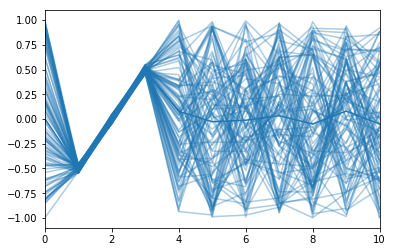

In [33]:
sns.tsplot(data=data,err_style="unit_traces")

In [6]:
for i in range(0,5):
    print(i)

0
1
2
3
4
